In [1]:
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from pyspark.shell import spark
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/

Using Python version 3.10.13 (main, Sep 11 2023 13:24:38)
Spark context Web UI available at http://DESKTOP-6PG46BR:4040
Spark context available as 'sc' (master = local[*], app id = local-1719789204023).
SparkSession available as 'spark'.


In [2]:
pd.set_option('display.max_columns', None)
alzheimer_data_path = 'Data/alzheimers_disease_data.csv'

In [3]:
spark_df = spark.read.csv(alzheimer_data_path, header = 'True', inferSchema=True)
spark_df.show()
readable_df = spark_df.toPandas()

+---------+---+------+---------+--------------+------------------+-------+------------------+-------------------+-------------------+-----------------+-----------------------+---------------------+--------+----------+----------+------------+----------+-----------+------------------+------------------+------------------+------------------------+------------------+--------------------+----------------+------------------+--------------------+---------+--------------+------------------+-------------------------+-------------+---------+--------------+
|PatientID|Age|Gender|Ethnicity|EducationLevel|               BMI|Smoking|AlcoholConsumption|   PhysicalActivity|        DietQuality|     SleepQuality|FamilyHistoryAlzheimers|CardiovascularDisease|Diabetes|Depression|HeadInjury|Hypertension|SystolicBP|DiastolicBP|  CholesterolTotal|    CholesterolLDL|    CholesterolHDL|CholesterolTriglycerides|              MMSE|FunctionalAssessment|MemoryComplaints|BehavioralProblems|                 ADL|Conf

In [4]:
# Drop the Doctor in Charge, As it is confiential data only 'XXXX' is a value
readable_df.drop(['DoctorInCharge'],axis=1, inplace=True)

# Enhance Data Readability

In [5]:
# Modify medical history data to be human readable
medical_history_dicts = {
    'Gender'                    : {0:'Male', 1:'Female'},
    'Ethnicity'                 : {0:'Caucasian', 1:'African American', 2:'Asian', 3:'Other'},
    'EducationLevel'            : {0:'None', 1:'High School', 2:"Bachelor's", 3: 'Higher'},
    'Smoking'                   : {0:'Non-Smoker', 1:'Smoker'},
    'FamilyHistoryAlzheimers'   : {0:'No Alzheimers in Family',1:'Alzheimers in Family'},
    'CardiovascularDisease'     : {0:'No Cardiovascular', 1:'Cardiovascular'},
    'Diabetes'                  : {0:'No Diabetes', 1:'Diabetes'},
    'Depression'                : {0:'No Depression', 1:'Depression'},
    'HeadInjury'                : {0:'No History of Head Injury', 1: 'History of Head Injury'},
    'Hypertension'              : {0:'Non-hypertensive', 1: 'Hypertensive'} 
}

for k, v in medical_history_dicts.items():
    readable_df.replace({k : v}, inplace=True)

In [6]:
# Modify cognitive and functional assessment data to be human readable
assessment_dicts = {
    'MemoryComplaints'      : {0:'No Memory Issues', 1:'Memory Complains'},
    'BehavioralProblems'    : {0:'No Behavioral Issues', 1:'Behavioral Issues'}
}

for k, v in assessment_dicts.items():
    readable_df.replace({k : v}, inplace=True)

In [7]:
# Modify symptom data to be human readable
symptom_dicts = {
    'Confusion'                 : {0: 'Not Confused', 1: 'Confused'},
    'Disorientation'            : {0: 'Not Disoriented', 1: 'Disoriented'},
    'PersonalityChanges'        : {0: 'No Personality Changes', 1: 'Personality Changes'},
    'DifficultyCompletingTasks' : {0: 'No Difficulty', 1: 'Difficulty'},
    'Forgetfulness'             : {0: 'Not forgetful', 1: 'Forgetful'}
}

for k, v in symptom_dicts.items():
    readable_df.replace({k : v}, inplace=True)

In [8]:
# Modify diagnosis data to be human readable
readable_df.replace({'Diagnosis' : {0: "No Alzheimer's Disease", 1: "Alzheimer's Disease"}}, inplace=True)

In [9]:
readable_df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,Male,Caucasian,Bachelor's,22.927749,Non-Smoker,13.297218,6.327112,1.347214,9.025679,No Alzheimers in Family,No Cardiovascular,Diabetes,Depression,No History of Head Injury,Non-hypertensive,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,No Memory Issues,No Behavioral Issues,1.725883,Not Confused,Not Disoriented,No Personality Changes,Difficulty,Not forgetful,No Alzheimer's Disease
1,4752,89,Male,Caucasian,None,26.827681,Non-Smoker,4.542524,7.619885,0.518767,7.151293,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,No Memory Issues,No Behavioral Issues,2.592424,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Forgetful,No Alzheimer's Disease
2,4753,73,Male,Other,High School,17.795882,Non-Smoker,19.555085,7.844988,1.826335,9.673574,Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,No Memory Issues,No Behavioral Issues,7.119548,Not Confused,Disoriented,No Personality Changes,Difficulty,Not forgetful,No Alzheimer's Disease
3,4754,74,Female,Caucasian,High School,33.800817,Smoker,12.209266,8.428001,7.435604,8.392554,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,No Memory Issues,Behavioral Issues,6.481226,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Not forgetful,No Alzheimer's Disease
4,4755,89,Male,Caucasian,None,20.716974,Non-Smoker,18.454356,6.310461,0.795498,5.597238,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,No Memory Issues,No Behavioral Issues,0.014691,Not Confused,Not Disoriented,Personality Changes,Difficulty,Not forgetful,No Alzheimer's Disease


# Visualize Data

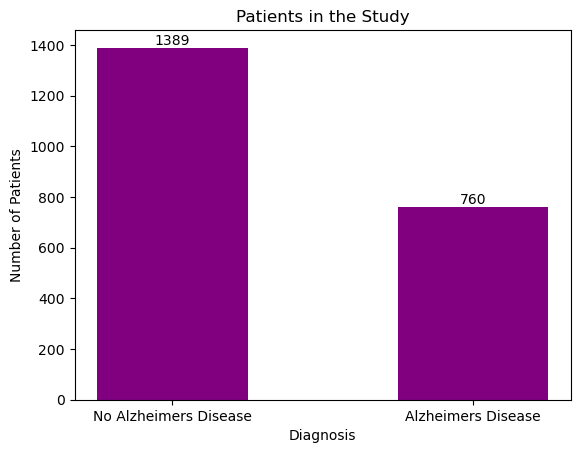

In [10]:
readable_df['BMI'] = readable_df['BMI'].astype('int')
values, bins, bars = plt.hist(readable_df['Diagnosis'], bins = 2, rwidth= .5, color= 'purple')
plt.title('Patients in the Study')
plt.xticks(ticks= [.25, .75], labels=['No Alzheimer''s Disease','Alzheimer''s Disease'])
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.bar_label(bars)
plt.show()

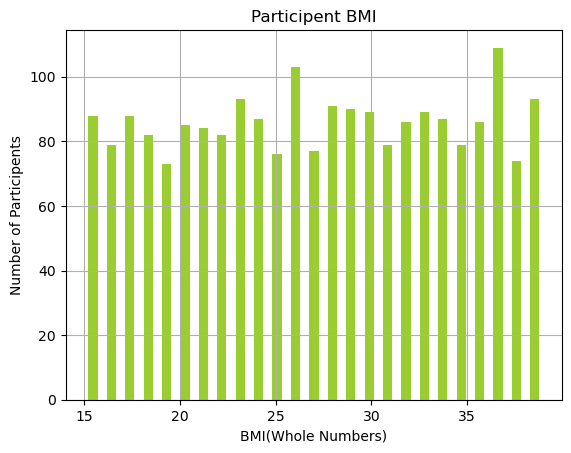

In [11]:
bins_BMI = readable_df['BMI'].max() - readable_df['BMI'].min()+1
readable_df['BMI'].hist(bins=bins_BMI, histtype = 'bar', rwidth = .5, color = 'yellowgreen')
plt.xlabel('BMI(Whole Numbers)')
plt.ylabel('Number of Participents')
plt.title('Participent BMI')
plt.show()

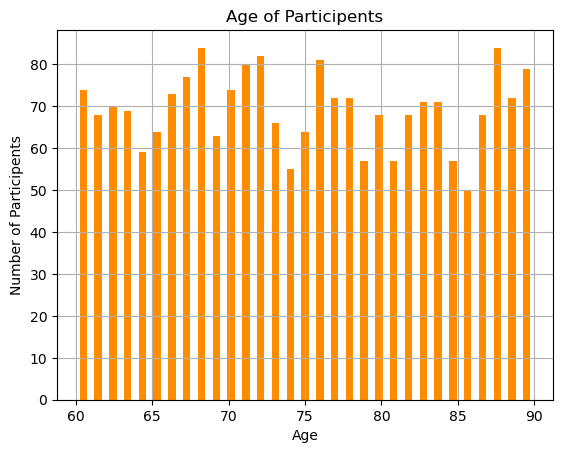

In [12]:
bins_Age = readable_df['Age'].astype('int').max() - readable_df['Age'].astype('int').min()+1
readable_df['Age'].hist(bins=bins_Age, rwidth = .5, color = 'darkorange')
plt.xlabel('Age')
plt.ylabel('Number of Participents')
plt.title('Age of Participents')
plt.show()

<Axes: title={'center': 'Study Paticipents by Gender'}>

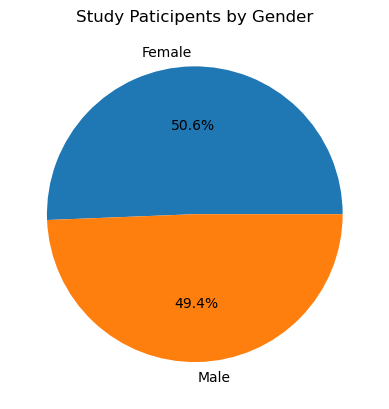

In [13]:
readable_df.groupby('Gender')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Gender',ylabel = "")

<Axes: title={'center': 'Study Paticipents by Ethnicity'}>

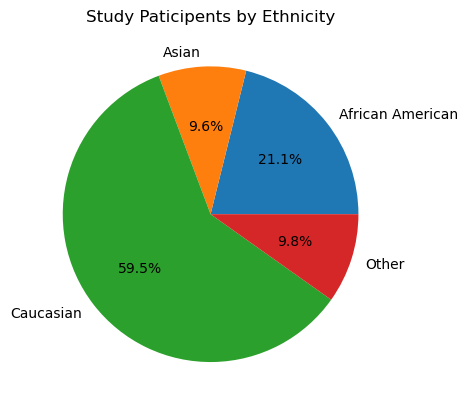

In [14]:
readable_df.groupby('Ethnicity')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Ethnicity',ylabel = "")

<Axes: title={'center': 'Study Paticipents by History'}>

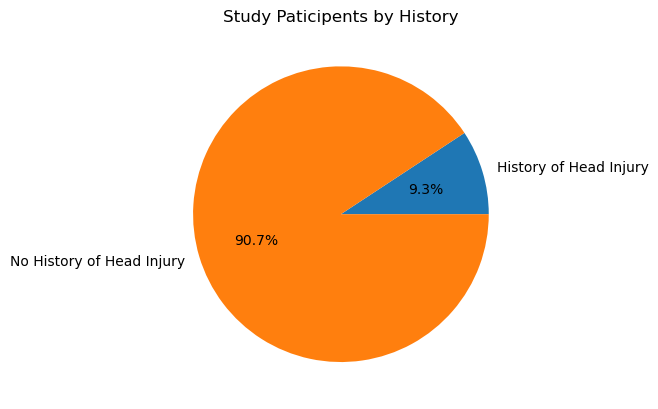

In [15]:
readable_df.groupby('HeadInjury')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by History',ylabel = "")

<Axes: title={'center': 'Study Paticipents by History'}>

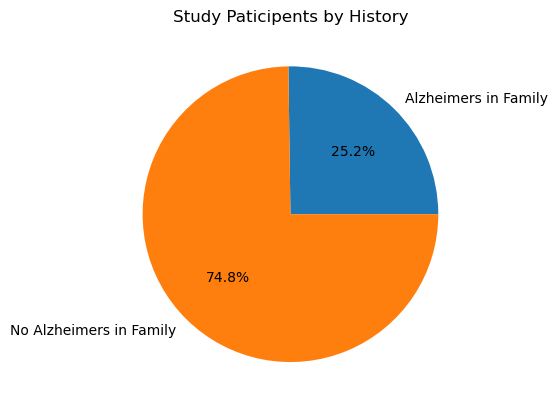

In [16]:
readable_df.groupby('FamilyHistoryAlzheimers')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by History',ylabel = "")

<Axes: title={'center': 'Study Paticipents by Diagnosis'}>

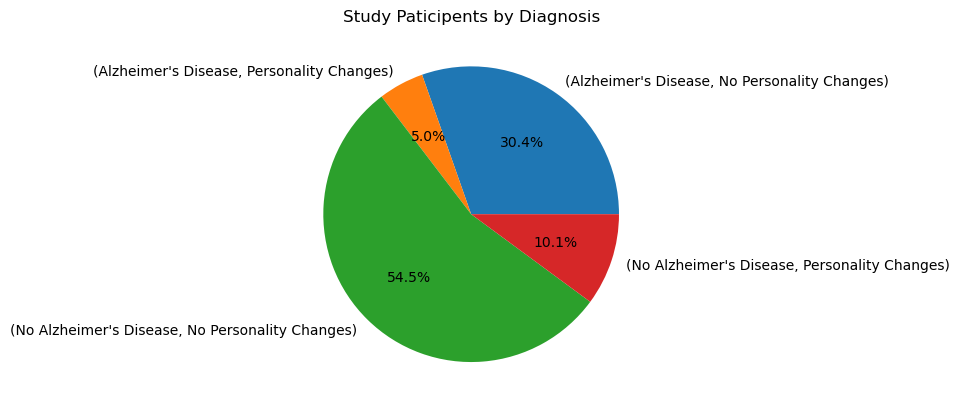

In [17]:
readable_df.groupby(['Diagnosis','PersonalityChanges'])['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Diagnosis',ylabel = "")

<Axes: title={'center': 'Study Paticipents by Diagnosis'}>

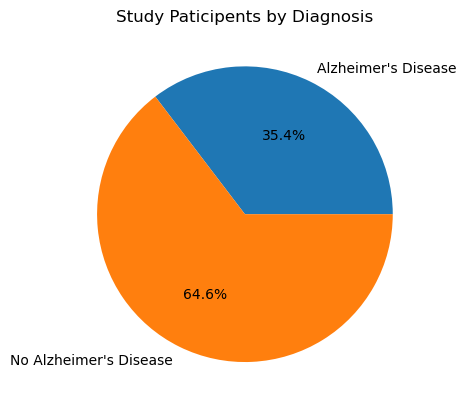

In [18]:
readable_df.groupby('Diagnosis')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Diagnosis',ylabel = "")

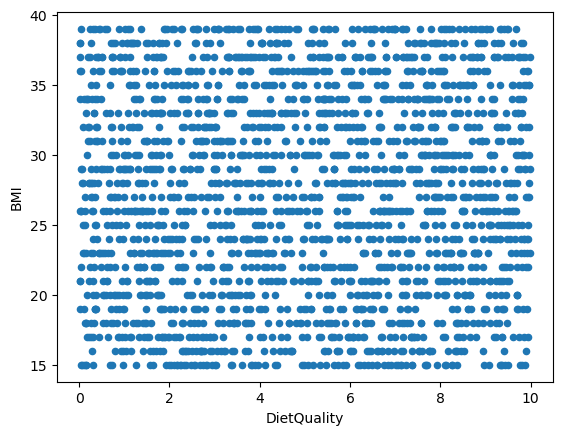

In [19]:
readable_df.plot(kind='scatter', x= 'DietQuality', y='BMI')

plt.show()

In [20]:
# selecting rows based on condition 'Diagnosis'] == 'Yes'
data_Diagnosed = readable_df[readable_df['Diagnosis'] == 'Alzheimer\'s Disease'] 
data_Diagnosed_count =  len(data_Diagnosed.index)
print('\n Number of participant : ', len(readable_df))
print('\n Number of participant diagnosed with  Alzheimer : ', data_Diagnosed_count)
#data_Diagnosed.head() 


 Number of participant :  2149

 Number of participant diagnosed with  Alzheimer :  760


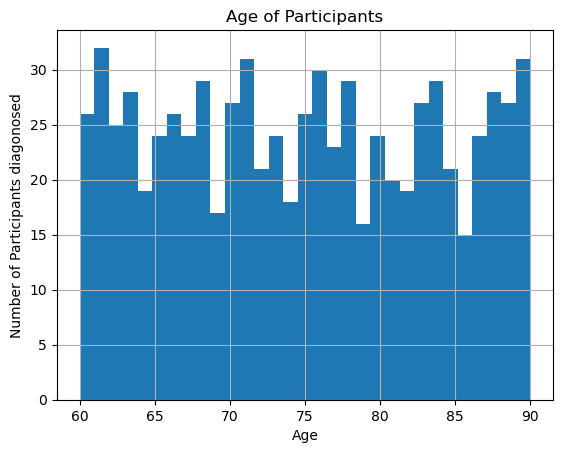

In [21]:
bins_Age = data_Diagnosed['Age'].astype('int').max() - data_Diagnosed['Age'].astype('int').min()+1
data_Diagnosed['Age'].hist(bins=bins_Age)
plt.xlabel('Age')
plt.ylabel('Number of Participants diagonosed')
plt.title('Age of Participants')
plt.show()


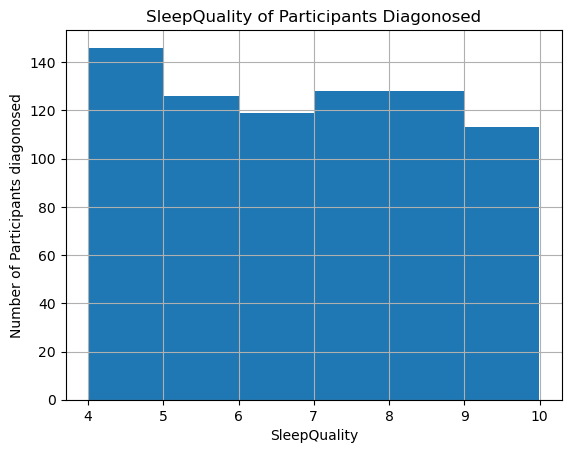

In [22]:
bins_Sleep = data_Diagnosed['SleepQuality'].astype('int').max() - data_Diagnosed['SleepQuality'].astype('int').min()+1
data_Diagnosed['SleepQuality'].hist(bins=bins_Sleep)
plt.xlabel('SleepQuality')
plt.ylabel('Number of Participants diagonosed')
plt.title('SleepQuality of Participants Diagonosed')
plt.show()

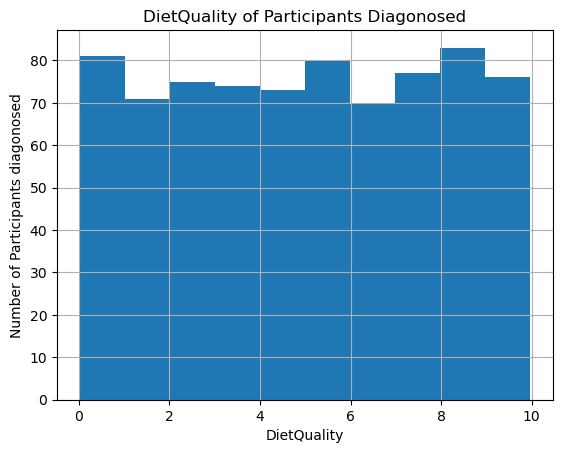

In [23]:
bins_Diat = data_Diagnosed['DietQuality'].astype('int').max() - data_Diagnosed['DietQuality'].astype('int').min()+1
data_Diagnosed['DietQuality'].hist(bins=bins_Diat)
plt.xlabel('DietQuality')
plt.ylabel('Number of Participants diagonosed')
plt.title('DietQuality of Participants Diagonosed')
plt.show()

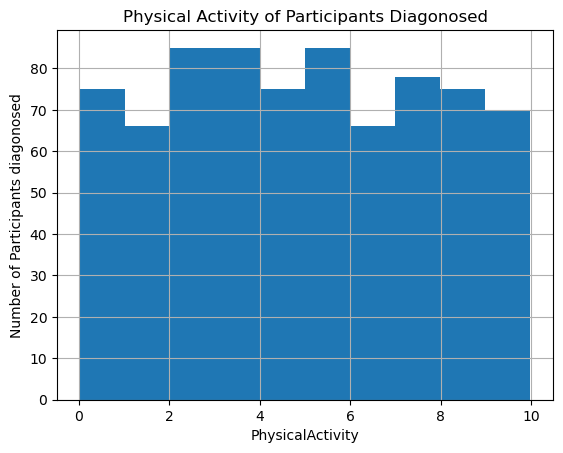

In [24]:
bins_Diat = data_Diagnosed['PhysicalActivity'].astype('int').max() - data_Diagnosed['PhysicalActivity'].astype('int').min()+1
data_Diagnosed['PhysicalActivity'].hist(bins=bins_Diat)
plt.xlabel('PhysicalActivity')
plt.ylabel('Number of Participants diagonosed')
plt.title('Physical Activity of Participants Diagonosed')
plt.show()

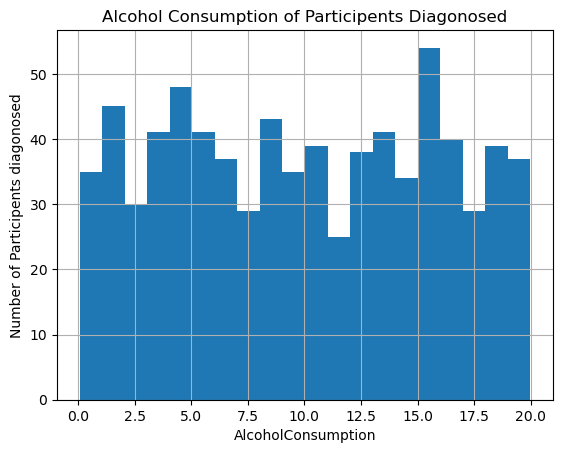

In [25]:
bins_Diat = data_Diagnosed['AlcoholConsumption'].astype('int').max() - data_Diagnosed['AlcoholConsumption'].astype('int').min()+1
data_Diagnosed['AlcoholConsumption'].hist(bins=bins_Diat)
plt.xlabel('AlcoholConsumption')
plt.ylabel('Number of Participents diagonosed')
plt.title('Alcohol Consumption of Participents Diagonosed')
plt.show()

<Axes: title={'center': 'Study Paticipants diagnosed with Alzheimer by Behavioral Problems'}>

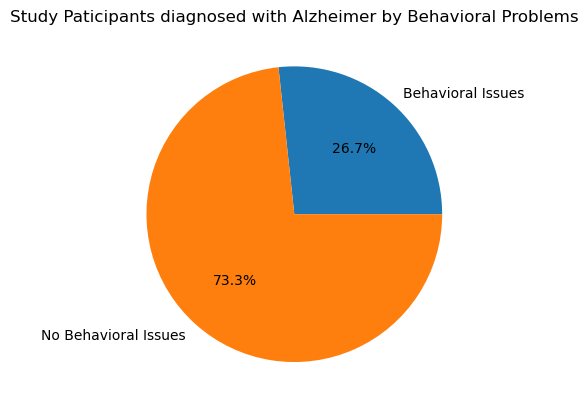

In [26]:
data_Diagnosed.groupby('BehavioralProblems')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipants diagnosed with Alzheimer by Behavioral Problems',ylabel = "")

<Axes: title={'center': 'Study Participants diagnosed with Alzheimer by Depression'}>

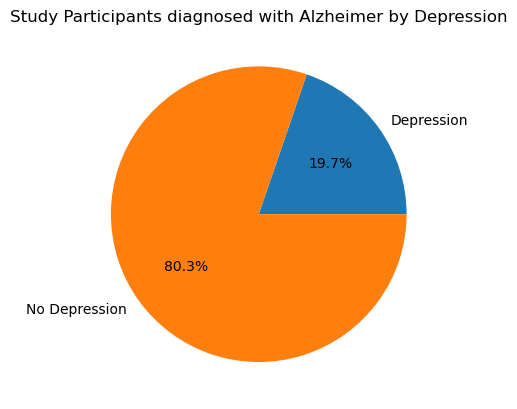

In [27]:
data_Diagnosed.groupby('Depression')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Participants diagnosed with Alzheimer by Depression',ylabel = "")

<Axes: title={'center': 'Study Participants diagnosed with Alzheimer by Family History'}>

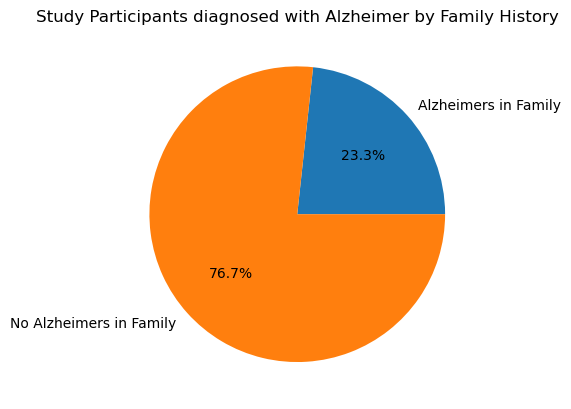

In [28]:
data_Diagnosed.groupby('FamilyHistoryAlzheimers')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Participants diagnosed with Alzheimer by Family History',ylabel = "")

<Axes: title={'center': 'Study Participants diagnosed with Alzheimer by EducationLevel'}>

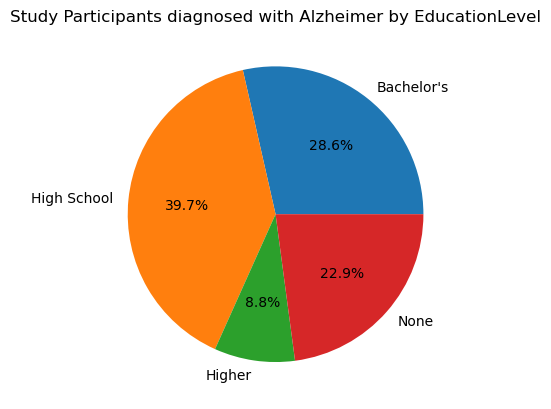

In [29]:
data_Diagnosed.groupby('EducationLevel')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Participants diagnosed with Alzheimer by EducationLevel',ylabel = "")

<Axes: title={'center': 'Study Participants diagnosed with Alzheimer by Confusion'}>

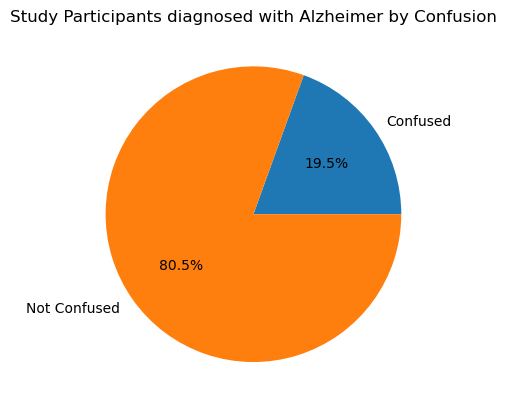

In [30]:
data_Diagnosed.groupby('Confusion')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Participants diagnosed with Alzheimer by Confusion',ylabel = "")

<Axes: title={'center': 'Study Participants diagnosed with Alzheimer by Ethnicity'}>

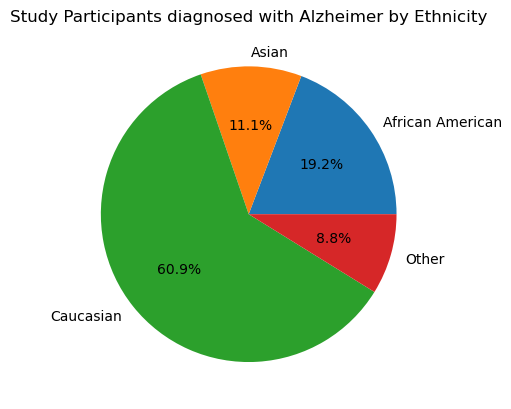

In [31]:
data_Diagnosed.groupby('Ethnicity')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Participants diagnosed with Alzheimer by Ethnicity',ylabel = "")

<Axes: title={'center': 'Study Participants diagnosed with Alzheimer by Depression and Head Injury'}>

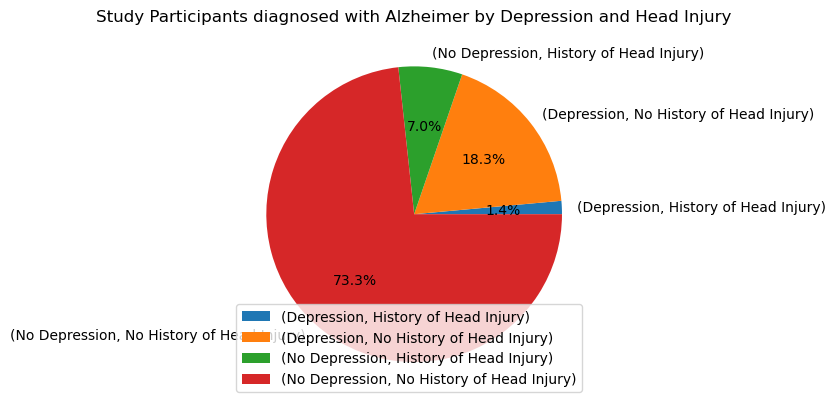

In [32]:
data_Diagnosed.groupby(['Depression','HeadInjury'])['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Participants diagnosed with Alzheimer by Depression and Head Injury',ylabel = "",legend = [""])

# Unsupervised Machine Learning

In [20]:
# Query all of the data except:
# PatientID:        unique identifier for each record
# DoctorInCharge:   confidential data
spark_df.createOrReplaceTempView('medical')
k_means_df = spark.sql('''
SELECT
    Age,
    Gender,
    Ethnicity,
    EducationLevel,
    BMI,
    Smoking,
    AlcoholConsumption, 
    PhysicalActivity, 
    DietQuality, 
    SleepQuality, 
    FamilyHistoryAlzheimers, 
    CardiovascularDisease,
    Diabetes,
    Depression,
    HeadInjury,
    Hypertension,
    SystolicBP,
    DiastolicBP,
    CholesterolTotal,
    CholesterolLDL,
    CholesterolHDL,
    CholesterolTriglycerides,
    MMSE,
    FunctionalAssessment,
    MemoryComplaints,
    BehavioralProblems,
    ADL,
    Confusion,
    Disorientation,
    PersonalityChanges,
    DifficultyCompletingTasks,
    Forgetfulness,
    Diagnosis
FROM medical
''').toPandas()

In [21]:
# Instantiate a PCA instance and fit the PCA model
pca = PCA(n_components=2)
alzheimer_pca = pca.fit_transform(k_means_df)

# Review the first 5 rows of the array of list data
alzheimer_pca[:5]

array([[ 66.04784241, -61.62461386],
       [-66.41087223,  68.47738249],
       [144.41205353,  41.26787262],
       [-49.68404599, -72.97104668],
       [-63.33595025, -27.43413363]])

In [22]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.6545923 , 0.11870419])

In [23]:
# Create the PCA DataFrame
alzheimer_pca_df = pd.DataFrame(
    alzheimer_pca,
    columns=["PCA1", "PCA2"]
)

# Compute inertia values for k from 1 to 10
k = list(range(1, 11))
inertia = []
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(alzheimer_pca_df)
    inertia.append(k_model.inertia_)
elbow_df = pd.DataFrame({'k' : k, 'inertia' : inertia})

In [24]:
# Plot the Elbow Curve
elbow_df.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

In [25]:
# Define and fit a model with 4 clusters
k_model = KMeans(n_clusters=4, random_state=0)
k_model.fit(alzheimer_pca_df)

# Make predictions
k_4 = k_model.predict(alzheimer_pca_df)

# Add a class column with the clusters
alzheimer_pca_df['diagnosis_prediction'] = k_4

In [26]:
# Plot the clusters
alzheimer_pca_df.hvplot.scatter(
    x='PCA1',
    y='PCA2',
    by='diagnosis_prediction'
)

:NdOverlay   [diagnosis_prediction]
   :Scatter   [PCA1]   (PCA2)

# Supervised Machine Learning - KNN

In [27]:
# Seperate the features, X,  from the target variable, y
X = k_means_df.drop(columns='Diagnosis')
y = k_means_df['Diagnosis']

# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [28]:
# Instantiate and fit the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)

# Create confusion matrix
cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred), 
    index=["Actual 0 (Don't have Alzheimers)", "Actual 1 (Have Alzheimers)"], 
    columns=["Predicted 0 (Test indicates don't have it)", "Predicted 1 (Test indicates have it)"]
)

# Display results
print("Confusion Matrix")
display(cm_df)
print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 0 (Test indicates don't have it),Predicted 1 (Test indicates have it)
Actual 0 (Don't have Alzheimers),295,52
Actual 1 (Have Alzheimers),102,89



Accuracy Score: 0.7137546468401487

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       347
           1       0.63      0.47      0.54       191

    accuracy                           0.71       538
   macro avg       0.69      0.66      0.66       538
weighted avg       0.70      0.71      0.70       538



The K-nearest neighbors (KNN) algorithm was used to predict whether a patient will have alzheimers based on their medical data with an accuracy of 71%.

# Supervised Machine Learning - Neural Networks

In [29]:
# Set up a container to hold model results
model_results = {}

## Model 1 - All Features

In [30]:
# Query all of the data except:
# PatientID:        unique identifier for each record
# DoctorInCharge:   confidential data
model_1_df = spark.sql('''
SELECT
    Age,
    Gender,
    Ethnicity,
    EducationLevel,
    BMI,
    Smoking,
    AlcoholConsumption, 
    PhysicalActivity, 
    DietQuality, 
    SleepQuality, 
    FamilyHistoryAlzheimers, 
    CardiovascularDisease,
    Diabetes,
    Depression,
    HeadInjury,
    Hypertension,
    SystolicBP,
    DiastolicBP,
    CholesterolTotal,
    CholesterolLDL,
    CholesterolHDL,
    CholesterolTriglycerides,
    MMSE,
    FunctionalAssessment,
    MemoryComplaints,
    BehavioralProblems,
    ADL,
    Confusion,
    Disorientation,
    PersonalityChanges,
    DifficultyCompletingTasks,
    Forgetfulness,
    Diagnosis
FROM medical
''').toPandas()

In [31]:
# Split preprocessed data into features and target arrays
X = model_1_df.drop(columns='Diagnosis')
y = model_1_df['Diagnosis']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Determine the number of input neurons
print(f'Input neurons: {len(X_train_scaled[0])}')

Input neurons: 32


In [32]:
# Define the model
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Input(shape=(32,)))
nn.add(tf.keras.layers.Dense(units=2, activation='tanh'))
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69 (276.00 B)

 Trainable params: 69 (276.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

results = []
epochs_trained = 0

for i in range(40):
    # Train the model
    trained_model = nn.fit(
        X_train_scaled, 
        y_train, 
        epochs=5,
        verbose=0
    )

    epochs_trained += len(trained_model.epoch)

    # Evaluate the model using the test data
    metrics = nn.evaluate(X_test_scaled, y_test, verbose=0)
    results.append({
        'Epochs Trained' : epochs_trained,
        'Loss' : metrics[0],
        'Accuracy' : metrics[1],
        'Precision' : metrics[2],
        'Recall' : metrics[3]
    })

results_df = pd.DataFrame(results)
results_df.set_index('Epochs Trained', inplace=True)
results_df.sort_values('Accuracy', ascending=False, inplace=True)
model_results['All Features'] = results_df

## Model 2 - RFE Columns

In [34]:
# Query the most useful colums from rfe_analysis
model_2_df = spark.sql('''
SELECT
    FunctionalAssessment,
    MemoryComplaints,
    ADL,
    Diagnosis
FROM medical
''').toPandas()

In [35]:
# Split preprocessed data into features and target arrays
X = model_2_df.drop(columns='Diagnosis')
y = model_2_df['Diagnosis']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Determine the number of input neurons
print(f'Input neurons: {len(X_train_scaled[0])}')

Input neurons: 3


In [36]:
# Define the model
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Input(shape=(3,)))
nn.add(tf.keras.layers.Dense(units=5, activation='tanh'))
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26 (104.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

results = []
epochs_trained = 0

for i in range(60):
    # Train the model
    trained_model = nn.fit(
        X_train_scaled, 
        y_train, 
        epochs=5,
        verbose=0
    )

    epochs_trained += len(trained_model.epoch)

    # Evaluate the model using the test data
    metrics = nn.evaluate(X_test_scaled, y_test, verbose=0)
    results.append({
        'Epochs Trained' : epochs_trained,
        'Loss' : metrics[0],
        'Accuracy' : metrics[1],
        'Precision' : metrics[2],
        'Recall' : metrics[3]
    })

results_df = pd.DataFrame(results)
results_df.set_index('Epochs Trained', inplace=True)
results_df.sort_values('Accuracy', ascending=False, inplace=True)
model_results['RFE Columns'] = results_df

## Model 3 - Non-RFE Columns

In [38]:
# Query all data except the most useful colums from rfe_analysis
model_3_df = spark.sql('''
SELECT
    Age,
    Gender,
    Ethnicity,
    EducationLevel,
    BMI,
    Smoking,
    AlcoholConsumption, 
    PhysicalActivity, 
    DietQuality, 
    SleepQuality, 
    FamilyHistoryAlzheimers, 
    CardiovascularDisease,
    Diabetes,
    Depression,
    HeadInjury,
    Hypertension,
    SystolicBP,
    DiastolicBP,
    CholesterolTotal,
    CholesterolLDL,
    CholesterolHDL,
    CholesterolTriglycerides,
    MMSE,
    BehavioralProblems,
    Confusion,
    Disorientation,
    PersonalityChanges,
    DifficultyCompletingTasks,
    Forgetfulness,
    Diagnosis
FROM medical
''').toPandas()

In [39]:
# Split preprocessed data into features and target arrays
X = model_3_df.drop(columns='Diagnosis')
y = model_3_df['Diagnosis']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Determine the number of input neurons
print(f'Input neurons: {len(X_train_scaled[0])}')

Input neurons: 29


In [40]:
# Define the model
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Input(shape=(29,)))
nn.add(tf.keras.layers.Dense(units=2, activation='tanh'))
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 2)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63 (252.00 B)

 Trainable params: 63 (252.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

results = []
epochs_trained = 0

for i in range(20):
    # Train the model
    trained_model = nn.fit(
        X_train_scaled, 
        y_train, 
        epochs=5,
        verbose=0
    )

    epochs_trained += len(trained_model.epoch)

    # Evaluate the model using the test data
    metrics = nn.evaluate(X_test_scaled, y_test, verbose=0)
    results.append({
        'Epochs Trained' : epochs_trained,
        'Loss' : metrics[0],
        'Accuracy' : metrics[1],
        'Precision' : metrics[2],
        'Recall' : metrics[3]
    })

results_df = pd.DataFrame(results)
results_df.set_index('Epochs Trained', inplace=True)
results_df.sort_values('Accuracy', ascending=False, inplace=True)
model_results['Non-RFE Columns'] = results_df

## Compare Model Results

In [42]:
def print_model_results(model_results):
    print('Minimum loss:      {} at epoch {}'.format(round(model_results['Loss'].min(), 4), model_results['Loss'].idxmin()))
    print('Maximum accuracy:  {} at epoch {}'.format(round(model_results['Accuracy'].max(), 4), model_results['Accuracy'].idxmax()))
    print('Maximum precision: {} at epoch {}'.format(round(model_results['Precision'].max(), 4), model_results['Precision'].idxmax()))
    print('Maximum recall:    {} at epoch {}'.format(round(model_results['Recall'].max(), 4), model_results['Recall'].idxmax()))

All Features
Minimum loss:      0.3423 at epoch 190
Maximum accuracy:  0.8643 at epoch 155
Maximum precision: 0.8405 at epoch 155
Maximum recall:    0.7446 at epoch 155

RFE Columns
Minimum loss:      0.3946 at epoch 300
Maximum accuracy:  0.8513 at epoch 220
Maximum precision: 0.7771 at epoch 10
Maximum recall:    0.7771 at epoch 265

Non-RFE Columns
Minimum loss:      0.635 at epoch 20
Maximum accuracy:  0.645 at epoch 55
Maximum precision: 0.5769 at epoch 55
Maximum recall:    0.3575 at epoch 5



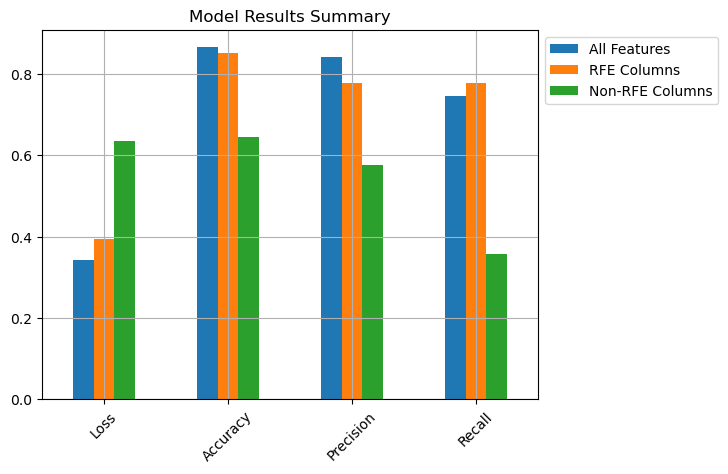

In [43]:
results_summary = []

for name, results in model_results.items():
    print(name)
    print_model_results(results)
    print()

    results_summary.append({
        'Model' : name,
        'Loss' : results['Loss'].min(),
        'Accuracy' : results['Accuracy'].max(),
        'Precision' : results['Precision'].max(),
        'Recall' : results['Recall'].max()
    })

summary_df = pd.DataFrame(results_summary)
summary_df.set_index('Model', inplace=True)
summary_df.transpose().plot(kind='bar', title='Model Results Summary', rot=45, grid=True).legend(bbox_to_anchor=(1, 1))